In [1]:
import numpy as np
import pyfits
import math
from math import log10
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from matplotlib import rc
import pickle
import os
import astropy as ap
from astropy.cosmology import WMAP7
from scipy import interpolate
import corner
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from __future__ import unicode_literals
# rcParams["font.size"] = 16
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = 'Ubuntu'
# rcParams['font.monospace'] = 'Ubuntu Mono'
rcParams['font.size'] = 20
rcParams['axes.labelsize'] = 17
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 1



In [2]:
os.chdir('/Users/nitya/Work/Data/Project1/measurements')


file2 = open(r'SFRP.pkl', 'rb')
d = pickle.load(file2, encoding = 'latin')
file2.close()
print(np.shape(d))

file1 = open(r'WISE_kcorrects_a', 'rb')
w = pickle.load(file1, encoding = 'latin')
file1.close()
print(w.dtype.names)
print(np.shape(w))



#Getting colors, kcorrect, fluxes
# There's one annoying 0 thing in N band nmgy_ivar - removing it!
indf = np.where(np.asarray(d['NMGY_IVAR'])[:,1]>0)[0]


d = d[indf]

(75476,)
('nsaid', 'z', 'kc1', 'kc2', 'kc3', 'kc4')
(75475,)


In [3]:
def jansky(a,b):
    ma = a*3631*(10.0**(-9.0))*(10**(b/(-2.5)))
    return ma
jansky = np.vectorize(jansky)
def jansky_err(a,b):
    ma_err = (a**(-0.5))*3631*(10.0**(-9.0))*(10**(b/(-2.5)))
    return ma_err
jansky_err = np.vectorize(jansky_err)
def wjansky(a):
    ma = 3631*(10**(-9.0))*a
    return ma
wjansky =  np.vectorize(wjansky)



ind = d['NSAID']
z = d['Z']
mtol = d['MTOL']
kc = d['KCORRECT']
mass = d['MASS']
opt = [d['ABSMAG'][:,1][i]-d['ABSMAG'][:,4][i] for i in range(len(ind))]
inf = [d['W1MAG'][i]-d['W3MAG'][i] for i in range(len(ind))]
#optical fluxes and flux errors
opt_flux = d['NMGY']
opt_flerr = d['NMGY_IVAR']
#WISE fluxes in nanomaggies
inf_flux = np.column_stack((d['W1_NMGY'],d['W2_NMGY'],d['W3_NMGY'],d['W4_NMGY']))
inf_flerr = np.column_stack((d['W1SIGM_NMGY'],d['W2SIGM_NMGY'],d['W3SIGM_NMGY'],d['W4SIGM_NMGY']))

print(np.shape(opt_flux), np.shape(kc))
flux = jansky(opt_flux,kc)
flerr = jansky_err(opt_flerr,kc)
wflux = wjansky(inf_flux)
wflerr = wjansky(inf_flerr)

w1flux = jansky(d['W1_NMGY'],w['kc1'])
w2flux = jansky(d['W2_NMGY'],w['kc2'])
w3flux = jansky(d['W3_NMGY'],w['kc3'])
w4flux = jansky(d['W4_NMGY'],w['kc4'])


#w1fluxerr = jansky_err(d['W1SIGM_NMGY'],w['kc1'])
#w2fluxerr = jansky_err(d['W2SIGM_NMGY'],w['kc2'])
#w3fluxerr = jansky_err(d['W3SIGM_NMGY'],w['kc3'])
#w4fluxerr = jansky_err(d['W4SIGM_NMGY'],w['kc4'])

(75475, 7) (75475, 7)


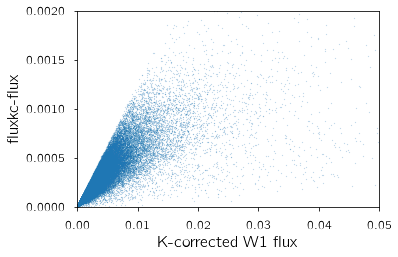

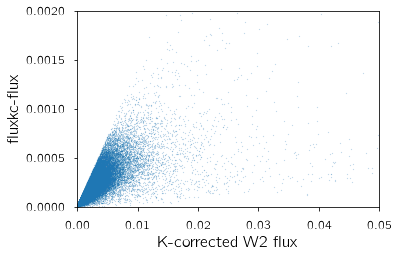

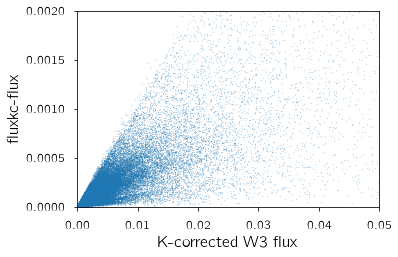

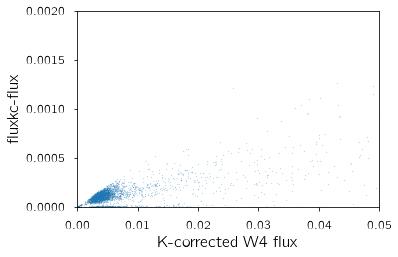

In [4]:
os.chdir('/Users/nitya/Desktop')

w1_residue = [w1flux[i]-wflux[:,0][i] for i in range(len(w1flux))]

plt.scatter(w1flux, w1_residue, s = 0.01)
plt.ylim(0,0.002)
plt.xlim(0,0.05)
#plt.yscale('log')
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W1 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W1flux_difference.pdf')
plt.show()


w2_residue = [w2flux[i]-wflux[:,1][i] for i in range(len(w2flux))]

plt.scatter(w2flux, w2_residue, s = 0.01)
plt.ylim(0,0.002)
plt.xlim(0,0.05)
#plt.yscale('log')
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W2 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W2flux_difference.pdf')
plt.show()


w3_residue = [w3flux[i]-wflux[:,2][i] for i in range(len(w3flux))]

plt.scatter(w3flux, w3_residue, s = 0.01)
plt.ylim(0,0.002)
plt.xlim(0,0.05)
#plt.yscale('log')
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W3 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W3flux_difference.pdf')
plt.show()


w4_residue = [w4flux[i]-wflux[:,3][i] for i in range(len(w4flux))]

plt.scatter(w4flux, w4_residue, s = 0.01)
plt.ylim(0,0.002)
plt.xlim(0,0.05)
#plt.yscale('log')
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W4 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W4flux_difference.pdf')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


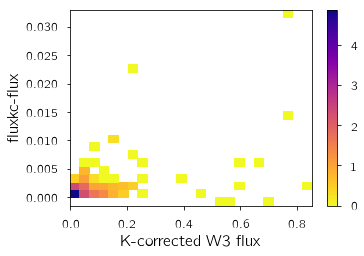

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


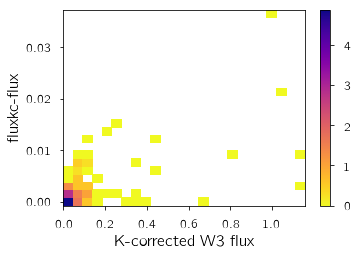

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


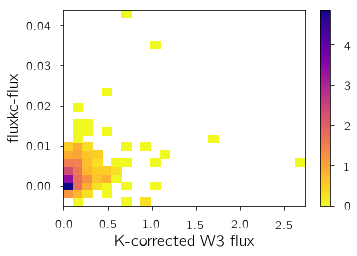

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


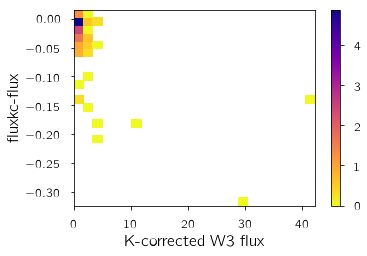

In [5]:
os.chdir('/Users/nitya/Desktop')

def thing(x,y):
    h = binned_statistic_2d(x,y,y,statistic = 'count',bins = (25,25))
    yedges = h[1]
    xedges = h[2]
    number = np.ma.array(h[0], mask = h[0] == 0)
    number = np.log10(number)
    plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.plasma_r)
    plt.colorbar()

thing(w1flux,w1_residue)
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W3 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W1DIFF.pdf')
plt.show()

thing(w2flux,w2_residue)
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W3 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W2DIFF.pdf')
plt.show()

thing(w3flux,w3_residue)
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W3 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W3DIFF.pdf')
plt.show()


thing(w4flux,w4_residue)
plt.ylabel('fluxkc-flux')
plt.xlabel('K-corrected W3 flux')
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2)
plt.savefig('W4DIFF.pdf')
plt.show()